In [ ]:
!pip install -qU accelerate transformers bitsandbytes peft datasets sentencepiece tqdm huggingface evaluate bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 781.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import torch
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from bert_score import score as bertscore
import warnings

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import login
login()

In [ ]:
model_name = "akshayparam/T2_tinyllama_chordgen"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model.eval()

tokenizer_config.json:   0%|          | 0.00/978 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2048, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=2048, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear(
            (base_layer): Linear(in_features=2048, out_features=256, bias=False)
            (lora_dropout): ModuleDict(
              (default):

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NLP/Datasets/t5_lyrics_chords_clean_v2.csv")
dataset = Dataset.from_pandas(df)

In [ ]:
def tokenize(example):
    prompt = f"""### Input Lyrics:
{example['input_text']}

### Chord Progression:
{example['target_text']}</s>"""

    encoded = tokenizer(prompt, truncation=True, padding="max_length", max_length=512)

    input_only = f"### Input Lyrics:\n{example['input_text']}\n\n### Chord Progression:\n"
    input_len = len(tokenizer(input_only, add_special_tokens=False)["input_ids"])

    labels = encoded["input_ids"][:]
    for i in range(input_len):
        if i < len(labels):
            labels[i] = -100

    labels = labels[:512]
    if len(labels) < 512:
        labels += [-100] * (512 - len(labels))

    return {
        "input_ids": encoded["input_ids"][:512],
        "attention_mask": encoded["attention_mask"][:512],
        "labels": labels,
        "input_text": example["input_text"],
        "target_text": example["target_text"]
    }

In [ ]:
tokenized_dataset = dataset.map(tokenize, remove_columns=dataset.column_names)
split_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
eval_dataset = split_dataset["test"]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from tqdm import tqdm

predictions = []
references = []
inputs = []

for example in tqdm(eval_dataset.select(range(100))):
    lyrics = example["input_text"]
    ref_chords = example["target_text"]

    prompt = f"""### Input Lyrics:
{lyrics}

### Chord Progression:"""

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            max_new_tokens=100,
            do_sample=False,
            temperature=0.7,
            pad_token_id=tokenizer.eos_token_id
        )

    generated = tokenizer.decode(output_ids[0][input_ids.shape[-1]:], skip_special_tokens=True)
    predictions.append(generated.strip())
    references.append(ref_chords.strip())
    inputs.append(lyrics.strip())


100%|██████████| 100/100 [06:46<00:00,  4.07s/it]


In [ ]:
P, R, F1 = bertscore(predictions, references, lang="en")
avg_f1 = F1.mean().item()

print(f"Average BERTScore F1 over {len(predictions)} samples: {avg_f1:.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore F1 over 100 samples: 0.7700


In [ ]:
precision_scores = P.tolist()
recall_scores = R.tolist()
f1_scores = F1.tolist()

avg_precision = sum(P).item() / len(P)
avg_recall = sum(R).item() / len(R)
avg_f1 = sum(F1).item() / len(F1)

print("Average BERTScore Metrics")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall:    {avg_recall:.4f}")
print(f"F1 Score:  {avg_f1:.4f}")

Average BERTScore Metrics
Precision: 0.7715
Recall:    0.7694
F1 Score:  0.7700


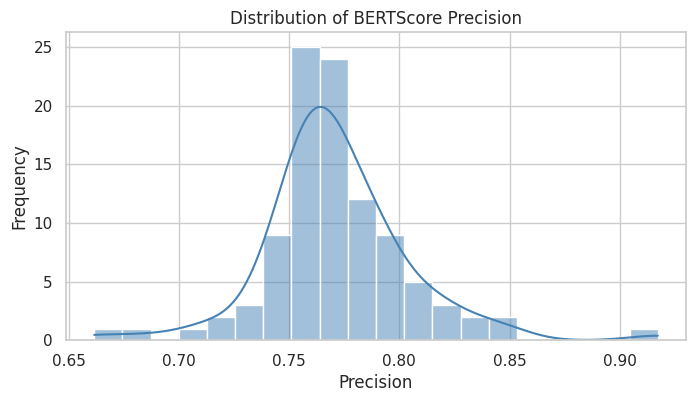

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.histplot(precision_scores, bins=20, kde=True, color='steelblue')
plt.title("Distribution of BERTScore Precision")
plt.xlabel("Precision")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


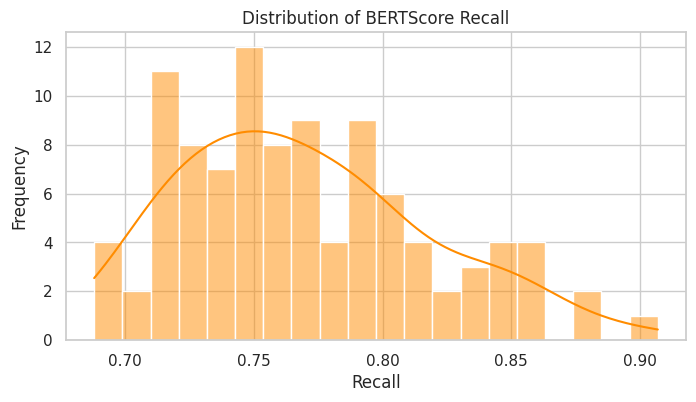

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(recall_scores, bins=20, kde=True, color='darkorange')
plt.title("Distribution of BERTScore Recall")
plt.xlabel("Recall")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


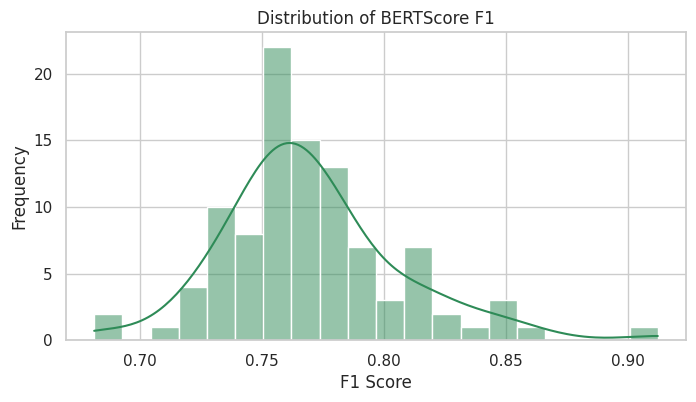

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(f1_scores, bins=20, kde=True, color='seagreen')
plt.title("Distribution of BERTScore F1")
plt.xlabel("F1 Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
